In [89]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.rcParams['figure.facecolor']=(1,1,1,1) # pycharm 绘图白底，看得清坐标
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

train = pd.read_csv("./train_set.csv")
test = pd.read_csv("./test_set.csv")

In [90]:
# 将训练集拆分一些出来做验证, 分层抽样
from sklearn.model_selection import StratifiedShuffleSplit
splt = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1)
for train_idx, vaild_idx in splt.split(train,train['y']):
    train_part = train.loc[train_idx]
    valid_part = train.loc[vaild_idx]
    
train_part_y = train_part['y']
valid_part_y = valid_part['y']
train_part['y'].value_counts()/len(train_part)
valid_part['y'].value_counts()/len(valid_part)

len(train[train['y']==1])/len(train['y'])

0.11695698542481336

In [91]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25317 entries, 0 to 25316
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         25317 non-null  int64 
 1   age        25317 non-null  int64 
 2   job        25317 non-null  object
 3   marital    25317 non-null  object
 4   education  25317 non-null  object
 5   default    25317 non-null  object
 6   balance    25317 non-null  int64 
 7   housing    25317 non-null  object
 8   loan       25317 non-null  object
 9   contact    25317 non-null  object
 10  day        25317 non-null  int64 
 11  month      25317 non-null  object
 12  duration   25317 non-null  int64 
 13  campaign   25317 non-null  int64 
 14  pdays      25317 non-null  int64 
 15  previous   25317 non-null  int64 
 16  poutcome   25317 non-null  object
 17  y          25317 non-null  int64 
dtypes: int64(9), object(9)
memory usage: 3.5+ MB


In [92]:
abs(train.corr()['y']).sort_values(ascending=False)

y           1.000000
ID          0.556627
duration    0.394746
pdays       0.107565
previous    0.088337
campaign    0.075173
balance     0.057564
day         0.031886
age         0.029916
Name: y, dtype: float64

In [93]:
s = (train.dtypes == 'object')
object_col = list(s[s].index)
object_col
num_col = list(set(train.columns) - set(object_col))
num_col

['y',
 'day',
 'balance',
 'age',
 'previous',
 'pdays',
 'duration',
 'ID',
 'campaign']

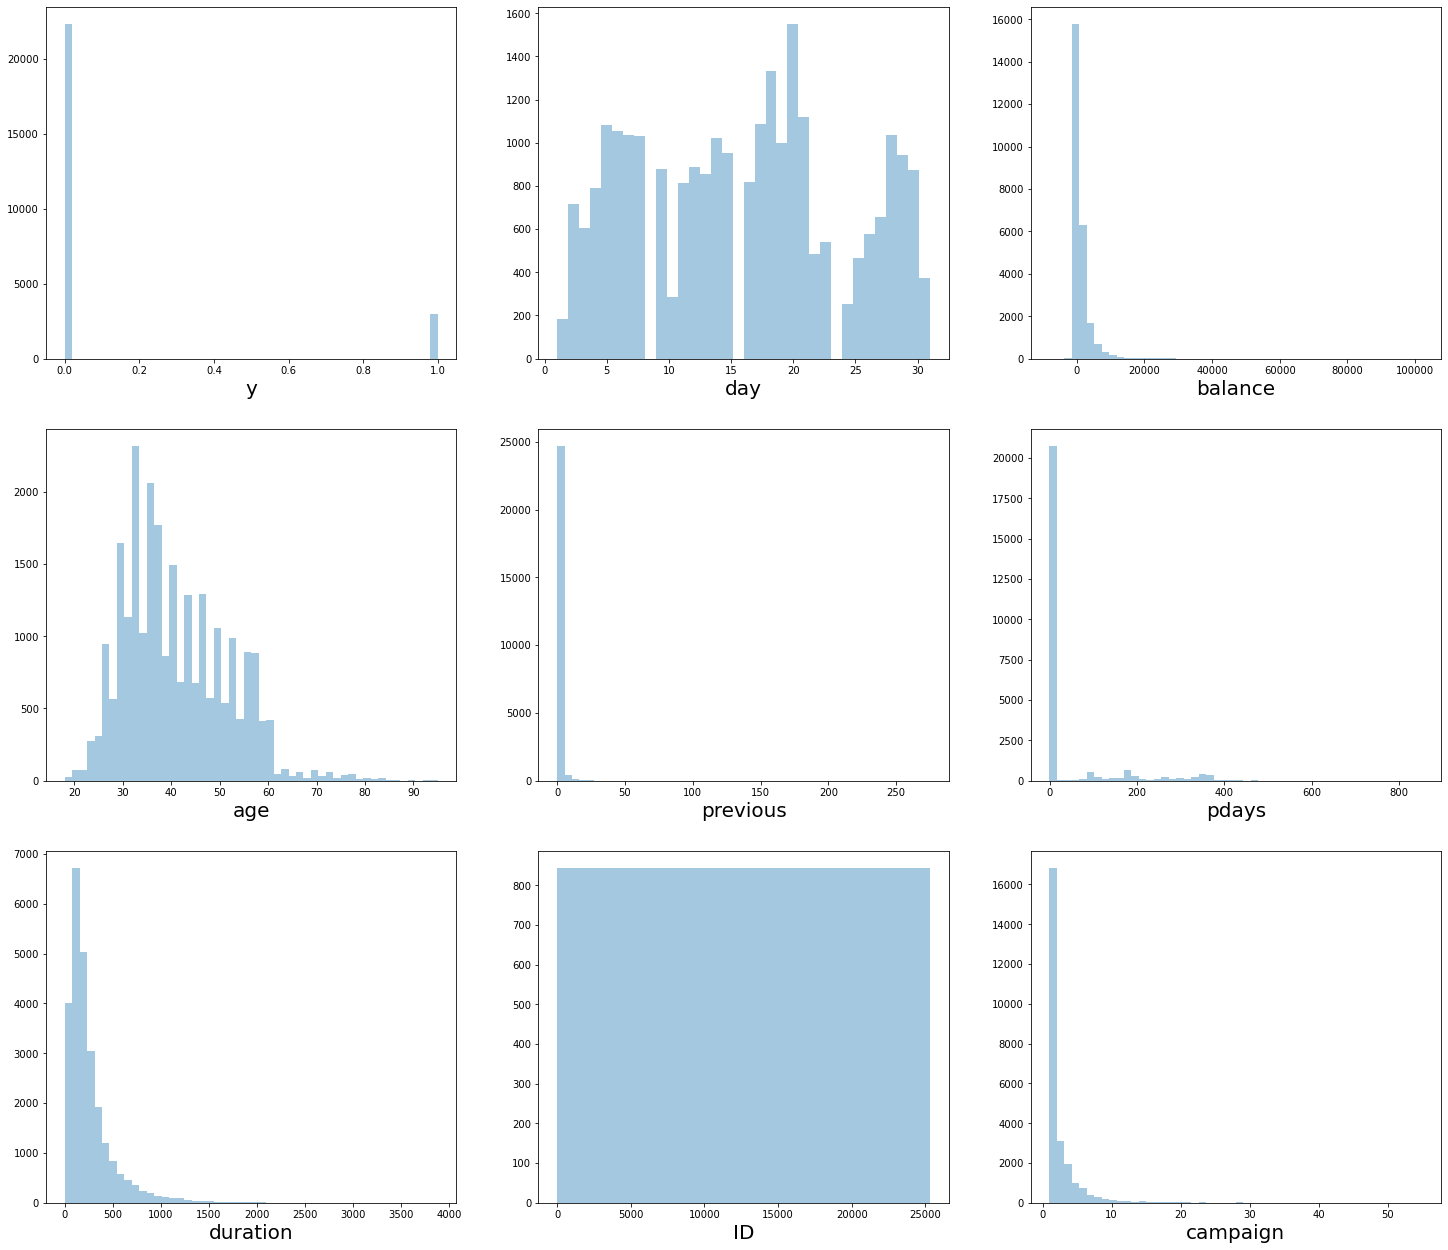

In [94]:
plt.figure(figsize=(25,22))
for (i,col) in enumerate(num_col):
    plt.subplot(3,3,i+1)
    sns.distplot(train[col], kde=False)
    plt.xlabel(col,size=20)
plt.show()  

In [95]:
len(train[train['y']==1])/len(train['y'])

0.11695698542481336

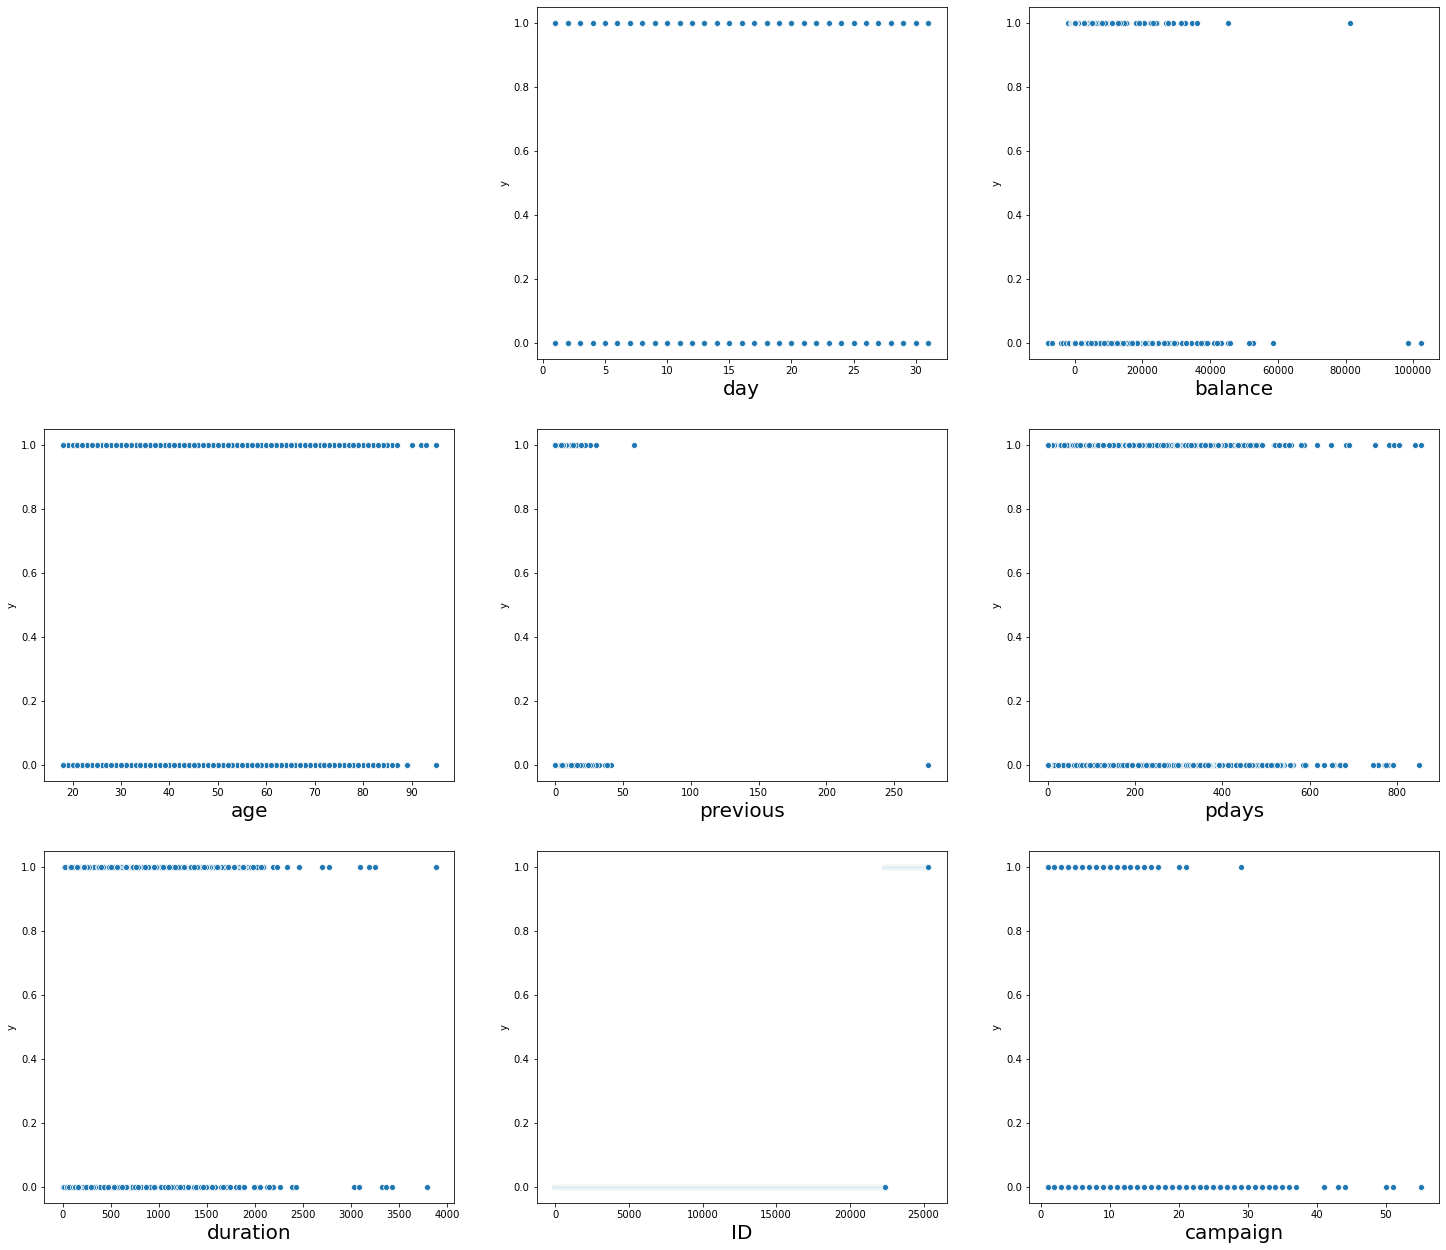

In [96]:
plt.figure(figsize=(25,22))
for (i,col) in enumerate(num_col):
    if col == 'y':
        continue
    plt.subplot(3,3,i+1)
    sns.scatterplot(x=train[col], y=train['y'])
    plt.xlabel(col,size=20)
plt.show()  

In [97]:
train['age'].max()

95

In [100]:
# 年龄划分，如果是树模型不用做此步，树模型会自己找最佳的切分点
def split_age(data, do=True):
    if not do:
        return data
    data['age_'] = ''
    for i, age in enumerate(data['age']):
        if age < 25:
            data['age_'][i] = 'A'
        elif age < 35:
            data['age_'][i] = 'B'
        elif age < 45:
            data['age_'][i] = 'C'
        elif age < 55:
            data['age_'][i] = 'D'
        elif age < 65:
            data['age_'][i] = 'E'
        else:
            data['age_'][i] = 'F'
    data = data.drop(['age'],axis=1)
    return data


# train = split_age(train)
# test = split_age(test)
# train_part = split_age(train_part)
# valid_part = split_age(valid_part)

train = split_age(train,False)
test = split_age(test,False)
train_part = split_age(train_part,False)
valid_part = split_age(valid_part,False)

# test['age_'].value_counts()
test.head(5)

,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,25318,51,housemaid,married,unknown,no,174,no,no,telephone,29,jul,308,3,-1,0,unknown
1,25319,32,management,married,tertiary,no,6059,yes,no,cellular,20,nov,110,2,-1,0,unknown
2,25320,60,retired,married,primary,no,0,no,no,telephone,30,jul,130,3,-1,0,unknown
3,25321,32,student,single,tertiary,no,64,no,no,cellular,30,jun,598,4,105,5,failure
4,25322,41,housemaid,married,secondary,no,0,yes,yes,cellular,15,jul,368,4,-1,0,unknown


In [101]:
for col in object_col:
    print(col, sorted(train[col].unique()))
    print(col, sorted(test[col].unique()))

job ['admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management', 'retired', 'self-employed', 'services', 'student', 'technician', 'unemployed', 'unknown']
job ['admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management', 'retired', 'self-employed', 'services', 'student', 'technician', 'unemployed', 'unknown']
marital ['divorced', 'married', 'single']
marital ['divorced', 'married', 'single']
education ['primary', 'secondary', 'tertiary', 'unknown']
education ['primary', 'secondary', 'tertiary', 'unknown']
default ['no', 'yes']
default ['no', 'yes']
housing ['no', 'yes']
housing ['no', 'yes']
loan ['no', 'yes']
loan ['no', 'yes']
contact ['cellular', 'telephone', 'unknown']
contact ['cellular', 'telephone', 'unknown']
month ['apr', 'aug', 'dec', 'feb', 'jan', 'jul', 'jun', 'mar', 'may', 'nov', 'oct', 'sep']
month ['apr', 'aug', 'dec', 'feb', 'jan', 'jul', 'jun', 'mar', 'may', 'nov', 'oct', 'sep']
poutcome ['failure', 'other', 'success', 'unknown']
poutcome ['failure', 'ot

In [102]:
train.isin(['unknown']).mean()*100

ID            0.000000
age           0.000000
job           0.643836
marital       0.000000
education     4.206660
default       0.000000
balance       0.000000
housing       0.000000
loan          0.000000
contact      28.759332
day           0.000000
month         0.000000
duration      0.000000
campaign      0.000000
pdays         0.000000
previous      0.000000
poutcome     81.672394
y             0.000000
dtype: float64

In [103]:
train['contact'].value_counts()

cellular     16391
unknown       7281
telephone     1645
Name: contact, dtype: int64

In [104]:
train['contact'][(train['contact']=='unknown') & (train['y']==0)].count()

6995

In [105]:
train['poutcome'].value_counts()

unknown    20677
failure     2735
other       1070
success      835
Name: poutcome, dtype: int64

In [106]:
# train['contact'][(train['contact']=='unknown')] = 'cellular'
# train['contact'].value_counts()

In [107]:
X_train = train.drop(['ID','y'], axis=1)
X_test = test.drop(['ID'], axis=1)
y_train = train['y']
train_part = train_part.drop(['ID','y'], axis=1)
valid_part = valid_part.drop(['ID','y'], axis=1)

def num_cat_splitor(X_train):
    s = (X_train.dtypes == 'object')
    object_cols = list(s[s].index)
    num_cols = list(set(X_train.columns) - set(object_cols))
    return num_cols, object_cols
num_cols, object_cols = num_cat_splitor(X_train)


In [108]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
        
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_cols)),
#         ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(object_cols)),
        ('cat_encoder', OneHotEncoder(sparse=False,handle_unknown='ignore')),
    ])
full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])
X_prepared = full_pipeline.fit_transform(X_train)

In [109]:
from sklearn.linear_model import Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score

perceptron = Perceptron()
rf = RandomForestClassifier()
knn = KNeighborsClassifier()
lr = LogisticRegression()
svc = SVC()
models = [perceptron, rf, knn, lr, svc]

for model in models:
    prepare_select_and_predict_pipeline = Pipeline([
        ('preparation', full_pipeline),
        ('model', model)
    ])
    prepare_select_and_predict_pipeline.fit(train_part,train_part_y)
    pred = prepare_select_and_predict_pipeline.predict(valid_part)
    print(model)
    print("auc score: ", roc_auc_score(valid_part_y, pred))
#     param_grid = [{
#     #     'preparation__num_pipeline__imputer__strategy': ['mean', 'median', 'most_frequent'],
#         'forst_reg__n_estimators' : [50,100, 150, 200,250,300,330,350],
#         'forst_reg__max_features':[45,50, 55, 65]
#     }]

    
#     grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=3,
#                                     scoring='roc_auc', verbose=2, n_jobs=-1)
#     grid_search_prep.fit(X_train,y_train)
#     grid_search_prep.best_params_
#     final_model = grid_search_prep.best_estimator_
#     y_pred_test = final_model.predict(X_test)
#     result = pd.DataFrame()
#     result['ID'] = test['ID']
#     result['pred'] = y_pred_test
#     result.to_csv('buy_product_pred.csv',index=False)


Perceptron()
auc score:  0.682912899482667
RandomForestClassifier()
auc score:  0.701966893100614
KNeighborsClassifier()
auc score:  0.6526948460087995


d:\program files\python38\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()
auc score:  0.6565703113668231
SVC()
auc score:  0.6623464922883527


In [ ]:
# 运行完，发邮件提醒
# 参考 https://blog.csdn.net/FransicZhang/article/details/83375299
import smtplib
from email.mime.text import MIMEText
from email.header import Header
 
mail_host = "smtp.qq.com"                           #邮箱服务器(这里采用的是QQ的)
mail_user = "846370521@qq.com"                         #发送者的邮箱地址
mail_pass = ""                             #发送者的邮箱授权码
sender = '846370521@qq.com'                            #与发送者的邮箱保持一致
receivers = ['846370521@qq.com','mingmingchen****@163.com']     #收件人的邮箱地址(可以一次给多人发送)
message = MIMEText('文本内容：程序运行完毕！', 'plain', 'utf-8')     #邮件的类型  这里采用的是纯文本的形式
message['From'] = Header('阿明', 'utf-8')
message['To'] = Header("还是阿明", 'utf-8')
subject = '邮件标头：程序运行完毕！'
message['Subject'] = Header(subject, 'utf-8')
try:
    smtpObj = smtplib.SMTP()
    smtpObj.connect(mail_host, 25)#开放的邮箱服务器的端口
    smtpObj.login(mail_user, mail_pass)
    smtpObj.sendmail(sender, receivers, message.as_string())
    print('发送成功!')
except smtplib.SMTPException:
    print('发送失败!')